In [1]:
import numpy as np
import json
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib
from collections import defaultdict
import math
from itertools import combinations

plt.rcParams['figure.figsize'] = [16, 4]
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
plt.rcParams.update({'font.size': 30})
   

from plot_utils import *

In [2]:
def plot_mouli_te_variation_with_pval(ax,run_list,pval_list,main_enum,plot_item_list,fname_pattern,title,label_prefix=""):
    #Getting the result dict
    result_dict_erm = get_all_result_dict(
                        run_list=run_list,
                        pval_list=pval_list,
                        enum=main_enum,
                        fname_pattern=fname_pattern+"probe_metric_list_erm.json",
    )
    result_dict_cad = get_all_result_dict(
                        run_list=run_list,
                        pval_list=pval_list,
                        enum=main_enum,
                        fname_pattern=fname_pattern+"probe_metric_list_cad.json",
    )
    
    
    #Getting the mouli's tv estimate of the TE
    avg_mouli_tv_pred = get_avg_tv_pred(
            run_list=run_list,
            pval_list=pval_list,
            tv_fname_pattern = fname_pattern+"mouli_pred_tv_data.json"
    )
    
    #Plotting the correlation
    offset_sub=1
    if "nlp_toy3" in fname_pattern:
        offset_sub=0
        correlation_items = ["y-tcausal","y-tconfound","y-tspurious",]
        for corr_item in correlation_items:
            corr_val_mean = np.array([result_dict_erm[pval][corr_item]["mean"] for pval in pval_list])
            corr_val_std = np.array([result_dict_erm[pval][corr_item]["std"] for pval in pval_list])
            ax[0].plot(pval_list,corr_val_mean,ls="-.",marker="o",label=label_prefix+corr_item,alpha=0.7)
            ax[0].fill_between(pval_list,corr_val_mean-corr_val_std,corr_val_mean+corr_val_std,alpha=0.3)
            ax[0].set_xlabel("pval")
            ax[0].set_ylim(0.0,1.0)
            ax[0].set_ylabel("topic correlation")
            ax[0].grid(True)
            ax[0].legend()
            ax[0].set_title(title)
            
    
    #plotting the avg mouli tv
    tv_pval_var_mean = np.array([avg_mouli_tv_pred[pval]["mean"] for pval in pval_list])
    tv_pval_var_std = np.array([avg_mouli_tv_pred[pval]["std"] for pval in pval_list])
    ax[1-offset_sub].plot(pval_list,tv_pval_var_mean,ls="-.",marker="o",alpha=0.7,label=label_prefix)
    ax[1-offset_sub].fill_between(pval_list,tv_pval_var_mean-tv_pval_var_std,tv_pval_var_mean+tv_pval_var_std,alpha=0.3)
    ax[1-offset_sub].set_xlabel("pval")
#     ax[1].set_ylim(0.0,1.0)
    ax[1-offset_sub].set_ylabel("|P(Y|phi(X)) - P(Y|X)|")
    ax[1-offset_sub].grid(True)
    ax[1-offset_sub].set_title(title)
    ax[1-offset_sub].legend()
    
    
    #Plotting the rest the items
    for pidx,plot_item in enumerate(plot_item_list):
        #Plotting the results
        item_yval_erm = np.array([result_dict_erm[pval][plot_item]["mean"] for pval in pval_list])
        yerr_erm = np.array([result_dict_erm[pval][plot_item]["std"] for pval in pval_list])
        #Plotting the item
        ax[pidx+2-offset_sub].plot(pval_list,item_yval_erm,label=label_prefix+"erm",ls="-.",marker="o",alpha=0.7)
        ax[pidx+2-offset_sub].fill_between(pval_list,item_yval_erm-yerr_erm,item_yval_erm+yerr_erm,alpha=0.3)
        
        #Plotting the results
        item_yval_cad = np.array([result_dict_cad[pval][plot_item]["mean"] for pval in pval_list])
        yerr_cad = np.array([result_dict_cad[pval][plot_item]["std"] for pval in pval_list])
        #Plotting the item
        ax[pidx+2-offset_sub].plot(pval_list,item_yval_cad,label=label_prefix+"cad",ls="-.",marker="o",alpha=0.7)
        ax[pidx+2-offset_sub].fill_between(pval_list,item_yval_cad-yerr_cad,item_yval_cad+yerr_cad,alpha=0.3)
        
        
        ax[pidx+2-offset_sub].set_xlabel("pval")
        #ax[pidx+2-offset_sub].set_ylim(-0.3,0.3)
        ax[pidx+2-offset_sub].set_ylabel(plot_item)
        ax[pidx+2-offset_sub].legend()
        ax[pidx+2-offset_sub].grid(True)
        ax[pidx+2-offset_sub].set_title(title)

In [3]:
def plot_mouli_selection_metrics(ax,run_list,topic_list,pval_list,main_enum,mouli_plot_item_list,probe_plot_item_list,combined_plot_item_list,inv_fname_pattern,savename=None,erm_fname_pattern=None):
    avg_mouli_selec_metric_dict = defaultdict(dict)
    all_result_dict = defaultdict(dict)
    if erm_fname_pattern==None:
        erm_fname_pattern=inv_fname_pattern
    
    
    
    #Going over all the topic subset and plotting the metric
    for myrandmode in ["train","notrain"]:
        for sidx in range(0,len(topic_list)+1):
            for topic_subset in combinations(topic_list,sidx):
                if sidx==0:
                    data_inv_fname_pattern  = inv_fname_pattern.format("{0}","{1}",myrandmode) + "mouli_erm_data.json"
                    probe_inv_fname_pattern = inv_fname_pattern.format("{0}","{1}",myrandmode) + "probe_metric_list_erm.json"
                else:
                    data_inv_fname_pattern  = inv_fname_pattern.format("{0}","{1}",myrandmode) + "mouli_({})_data.json".format(",".join(topic_subset))
                    probe_inv_fname_pattern = inv_fname_pattern.format("{0}","{1}",myrandmode) + "probe_metric_list_({})_cad.json".format(",".join(topic_subset))
                
                
                avg_mouli_selec_metric_dict[myrandmode][sort_topic_tuple(topic_subset)] = get_avg_tv_pred(
                                         run_list= run_list,
                                         pval_list=pval_list,
                                         tv_fname_pattern=data_inv_fname_pattern,
                                         item_list=mouli_plot_item_list,
                )

                all_result_dict[myrandmode][sort_topic_tuple(topic_subset)]= get_all_result_dict(
                            run_list=run_list,
                            pval_list=pval_list,
                            enum=main_enum,
                            fname_pattern=probe_inv_fname_pattern,
                )

    
    #Merging the dict
    for model in all_result_dict["train"].keys():
        for pval in all_result_dict["train"][model].keys():
            for item in all_result_dict["train"][model][pval].keys():
                avg_mouli_selec_metric_dict["train"][model][pval][item] = all_result_dict["train"][model][pval][item]
                avg_mouli_selec_metric_dict["notrain"][model][pval][item] = all_result_dict["notrain"][model][pval][item]

    
    #Generating the comnined score for every model
    for model in avg_mouli_selec_metric_dict["train"].keys():
        for pval in pval_list:
            mouli_score,mouli_score_std = get_model_mouli_score(topic_list,avg_mouli_selec_metric_dict,model,pval)
            
            avg_mouli_selec_metric_dict["train"][model][pval]["mouli_score"]["mean"]=mouli_score
            avg_mouli_selec_metric_dict["train"][model][pval]["mouli_score"]["std"]=mouli_score_std
            
            avg_mouli_selec_metric_dict["notrain"][model][pval]["mouli_score"]["mean"]=mouli_score
            avg_mouli_selec_metric_dict["notrain"][model][pval]["mouli_score"]["std"]=mouli_score_std
    
    #Now we will plot one by one for all the plot items for all the invariant models
    for inv_model,avg_mouli_selec_metric in avg_mouli_selec_metric_dict["notrain"].items():
        for pidx,plot_item in enumerate(combined_plot_item_list):
            if plot_item == "best_train_main_random_metric":
                #Plotting the results
                item_yval = np.array([avg_mouli_selec_metric_dict["train"][inv_model][pval][plot_item]["mean"] for pval in pval_list])
                yerr = np.array([avg_mouli_selec_metric_dict["train"][inv_model][pval][plot_item]["std"] for pval in pval_list])
            else:
                #Plotting the results
                item_yval = np.array([avg_mouli_selec_metric[pval][plot_item]["mean"] for pval in pval_list])
                yerr = np.array([avg_mouli_selec_metric[pval][plot_item]["std"] for pval in pval_list])
            #Plotting the item
            label = ",".join(inv_model) if len(inv_model)!=0 else "()"
            
            try:
                ax[pidx].plot(pval_list,item_yval,label=label,ls="-.",marker="o",alpha=0.7)
                ax[pidx].fill_between(pval_list,item_yval-yerr,item_yval+yerr,alpha=0.3)


                ax[pidx].set_xlabel("pval")
                #ax[pidx+2-offset_sub].set_ylim(-0.3,0.3)
                ax[pidx].set_ylabel(plot_item)
                ax[pidx].legend()
                ax[pidx].grid(True)
                #ax[pidx].set_title(title)
            except:
                ax.plot(pval_list,item_yval,label=label,ls="-.",marker="o",alpha=0.7)
                ax.fill_between(pval_list,item_yval-yerr,item_yval+yerr,alpha=0.3)


                ax.set_xlabel("predictive correlation ($\kappa$)")
                #ax[pidx+2-offset_sub].set_ylim(-0.3,0.3)
                if plot_item=="mouli_score":
                    ax.set_ylabel("Attribute Score (Mouli+CAD)")
                ax.legend()
                ax.grid(True)
                #ax[pidx].set_title(title)
    
    if savename!=None:
        plt.savefig(savename+".pdf", format="pdf", bbox_inches="tight")
    
    return avg_mouli_selec_metric_dict

# TOY3 dataset

## Plotting the metric used for model selection in Mouli

### Invariance using te reg

model:()			 score:-4.965647379557292
model:('causal',)			 score:-24.546529134114582
model:('spurious',)			 score:-62.275960286458336
model:('causal', 'spurious')			 score:-66.81723022460938
Initial Edge List:[], initial score:-66.81723022460938
Starting the addition phase
Candidate topic:causal	 score:-62.275960286458336
Candidate topic:spurious	 score:-24.546529134114582
Starting the removal phase
Final Invariance List: ('causal', 'spurious')
---------------------------------------------------------------------
pval: 0.5
selected invariance list:  ('causal', 'spurious')
---------------------------------------------------------------------







model:()			 score:-13.349517822265625
model:('causal',)			 score:-29.394083658854168
model:('spurious',)			 score:-62.2275390625
model:('causal', 'spurious')			 score:-76.8598124186198
Initial Edge List:[], initial score:-76.8598124186198
Starting the addition phase
Candidate topic:causal	 score:-62.2275390625
Candidate topic:spurious	 score:-

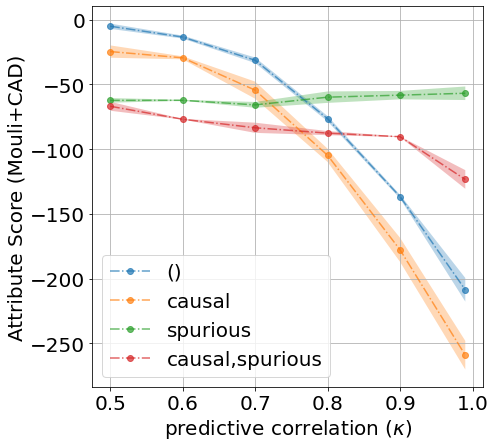

In [5]:
run_list=[0,1,2]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]

main_enum=20
topic_name_list = ["causal","spurious"] #["causal","spurious"]
topic_name_in_fname = "all"
sample=1000
noise=0.0
mvsel_mode="loss"
dcf=1.0 #0.0,0.5,1.0
telambda=0


mouli_plot_item_list=[
            "best_train_main_metric",
            "best_train_main_random_metric",
            "mouli_score",
            "best_valid_main_acc",
            "best_valid_main_smin_acc",
            "best_valid_main_pdelta",
]

probe_plot_item_list = [
            "acc:main",
            "topic0_smin",
            "topic0_smaj",
            "topic0_pdelta_all",
]

# combined_plot_item_list = mouli_plot_item_list + probe_plot_item_list 

combined_plot_item_list = [
            "mouli_score"
]


inv_fname_pattern = "dataset/nlp_toy3/nlp_logs/cad.moulis1toy3.rnum({}).topic({}).sample({}).noise({}).pvaltsp({}).dcf({}).mvsel({}).telambda({}).myrandmode({})/"



plt.rcParams['figure.figsize'] = [7,7*(len(combined_plot_item_list))]
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(len(combined_plot_item_list),)


avg_mouli_selec_metric_dict=plot_mouli_selection_metrics(ax=ax,
                                     run_list=run_list,
                                     topic_list=topic_name_list,
                                     pval_list=pval_list,
                                     main_enum=main_enum,
                                     mouli_plot_item_list=mouli_plot_item_list,
                                     probe_plot_item_list=probe_plot_item_list,
                                     combined_plot_item_list = combined_plot_item_list,
                                     inv_fname_pattern=inv_fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name_in_fname,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    dcf,
                                                                    mvsel_mode,
                                                                    telambda,
                                                                    "{2}"
                                    ),
                                    savename="toy3_mouli_score_all_topic",
                                                
)

for pval in pval_list:
    for model in avg_mouli_selec_metric_dict["train"].keys():
        print("model:{}\t\t\t score:{}".format(
                                model,
                                avg_mouli_selec_metric_dict["train"][model][pval]["mouli_score"]["mean"],
        ))
    print("=====================================================================")
    edge_list = ges_minimize(pval,topic_name_list,avg_mouli_selec_metric_dict)
    print("---------------------------------------------------------------------")
    print("pval:",pval)
    print("selected invariance list: ",get_topic_complement(edge_list,topic_name_list))
    print("---------------------------------------------------------------------\n\n\n\n\n\n\n")
plt.show()

# MNIST34 dataset

### inv using tereg

model:()			 score:-1324.3414713541667
model:('color',)			 score:1.4055989583333333
model:('rotation',)			 score:-1073.2029622395833
model:('color', 'rotation')			 score:0.4078776041666667
Initial Edge List:[], initial score:0.4078776041666667
Starting the addition phase
Candidate topic:color	 score:-1073.2029622395833
Candidate topic:rotation	 score:1.4055989583333333

Adding edge: color
Score after adding edge: -1073.2029622395833
Candidate topic:rotation	 score:-1324.3414713541667

Adding edge: rotation
Score after adding edge: -1324.3414713541667
Starting the removal phase
Candidate topic:color	 score:1.4055989583333333
Candidate topic:rotation	 score:-1073.2029622395833
Final Invariance List: ()
---------------------------------------------------------------------
pval: 0.5
selected invariance list:  ()
---------------------------------------------------------------------







model:()			 score:-1301.7991536458333
model:('color',)			 score:1.4070638020833333
model:('rotation',)		

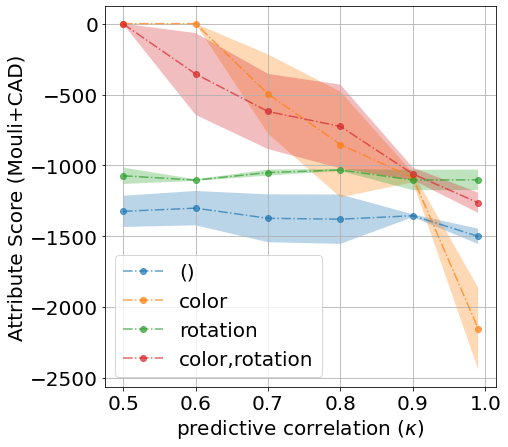

In [6]:
run_list=[0,1,2]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]

main_enum=20
topic_name_list = ["color","rotation"] #["color","rotation"]
topic_name_in_fname = "all"
sample=10000
noise=0.3
mvsel_mode="loss"
dcf=0.0 #0.0,0.5,1.0
telambda=0 #1 10 100 1000


mouli_plot_item_list=[
            "best_train_main_metric",
            "best_train_main_random_metric",
            "mouli_score",
            "best_valid_main_acc",
            "best_valid_main_smin_acc",
            "best_valid_main_pdelta",
]


probe_plot_item_list = [
            "acc:main",
            "topic0_smin",
            "topic0_smaj",
            "topic0_pdelta_all",
]



# combined_plot_item_list = mouli_plot_item_list + probe_plot_item_list
combined_plot_item_list = [
            "mouli_score"
]




inv_fname_pattern = "dataset/mnist/nlp_logs/cad.moulis1mnist.rnum({}).topic({}).sample({}).noise({}).pvaltsp({}).dcf({}).mvsel({}).telambda({}).myrandmode({})/"


plt.rcParams['figure.figsize'] = [7,7*(len(combined_plot_item_list))]
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(len(combined_plot_item_list),)


avg_mouli_selec_metric_dict=plot_mouli_selection_metrics(ax=ax,
                                     run_list=run_list,
                                     topic_list=topic_name_list,
                                     pval_list=pval_list,
                                     main_enum=main_enum,
                                     mouli_plot_item_list=mouli_plot_item_list,
                                     probe_plot_item_list=probe_plot_item_list,
                                     combined_plot_item_list=combined_plot_item_list,
                                     inv_fname_pattern=inv_fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name_in_fname,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    dcf,
                                                                    mvsel_mode,
                                                                    telambda,
                                                                    "{2}",
                                     ),
                                     savename="mnist_mouli_score_all_topic",
)

for pval in pval_list:
    for model in avg_mouli_selec_metric_dict["notrain"].keys():
        print("model:{}\t\t\t score:{}".format(
                                model,
                                avg_mouli_selec_metric_dict["notrain"][model][pval]["mouli_score"]["mean"],
        ))
    print("=====================================================================")
    edge_list = ges_minimize(pval,topic_name_list,avg_mouli_selec_metric_dict)
    print("---------------------------------------------------------------------")
    print("pval:",pval)
    print("selected invariance list: ",get_topic_complement(edge_list,topic_name_list))
    print("---------------------------------------------------------------------\n\n\n\n\n\n\n")
plt.show()

# CivilComments dataset

### using te_reg for inv

model:()			 score:5.995890299479167
model:('religion',)			 score:-1228.0299886067708
Initial Edge List:[], initial score:-1228.0299886067708
Starting the addition phase
Candidate topic:religion	 score:5.995890299479167
Starting the removal phase
Final Invariance List: ('religion',)
---------------------------------------------------------------------
pval: 0.5
selected invariance list:  ('religion',)
---------------------------------------------------------------------







model:()			 score:2.7618204752604165
model:('religion',)			 score:-875.5004069010416
Initial Edge List:[], initial score:-875.5004069010416
Starting the addition phase
Candidate topic:religion	 score:2.7618204752604165
Starting the removal phase
Final Invariance List: ('religion',)
---------------------------------------------------------------------
pval: 0.6
selected invariance list:  ('religion',)
---------------------------------------------------------------------







model:()			 score:1.4170125325520833
m

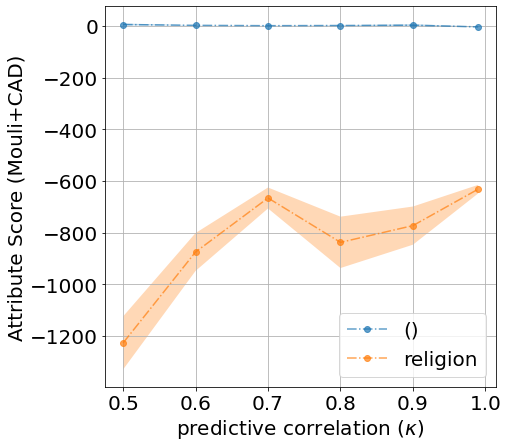

In [9]:
run_list=[0,1,2]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]

main_enum=20
# topic_name_list = ["race",]
# topic_name_list = ["gender",]
# sample=5000

topic_name_list = ["religion",]
sample=4000

topic_name_in_fname = topic_name_list[0]
noise=0.0
mvsel_mode="loss"
telambda=0   #1,10,100,1000



mouli_plot_item_list=[
            "best_train_main_metric",
            "best_train_main_random_metric",
            "mouli_score",
            "best_valid_main_acc",
            "best_valid_main_smin_acc",
            "best_valid_main_pdelta",
]


probe_plot_item_list = [
            "acc:main",
            "topic0_smin",
            "topic0_smaj",
            "topic0_pdelta_all",
]



# combined_plot_item_list = mouli_plot_item_list + probe_plot_item_list
combined_plot_item_list = [
            "mouli_score"
]



inv_fname_pattern = "dataset/civilcomments/nlp_logs/cad.moulis1civil.rnum({}).topic({}).sample({}).noise({}).pval({}).mvsel({}).telambda({})/"
# erm_fname_pattern = "dataset/civilcomments/nlp_logs/cad.moulis1civil.rnum({}).topic({}).sample({}).noise({}).pval({}).mvsel({})/"

plt.rcParams['figure.figsize'] = [7,7*(len(combined_plot_item_list))]
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.rcParams.update({'font.size': 20})
fig,ax = plt.subplots(len(combined_plot_item_list),)



avg_mouli_selec_metric_dict=plot_mouli_selection_metrics(ax=ax,
                                     run_list=run_list,
                                     topic_list=topic_name_list,
                                     pval_list=pval_list,
                                     main_enum=main_enum,
                                     mouli_plot_item_list=mouli_plot_item_list,
                                     probe_plot_item_list=probe_plot_item_list,
                                     combined_plot_item_list=combined_plot_item_list,
                                     inv_fname_pattern=inv_fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name_in_fname,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    mvsel_mode,
                                                                    telambda,
                                                                    "{2}",
                                     ),
                                     savename="civil_{}_mouli_score".format(topic_name_list[-1]),
)

for pval in pval_list:
    for model in avg_mouli_selec_metric_dict["notrain"].keys():
        print("model:{}\t\t\t score:{}".format(
                                model,
                                avg_mouli_selec_metric_dict["notrain"][model][pval]["mouli_score"]["mean"],
        ))
    print("=====================================================================")
    edge_list = ges_minimize(pval,topic_name_list,avg_mouli_selec_metric_dict)
    print("---------------------------------------------------------------------")
    print("pval:",pval)
    print("selected invariance list: ",get_topic_complement(edge_list,topic_name_list))
    print("---------------------------------------------------------------------\n\n\n\n\n\n\n")
plt.show()

# AAE dataset

### Inv using te reg

model:()			 score:-2434.8588625590005
model:('race',)			 score:-3447.680908203125
Initial Edge List:[], initial score:-3447.680908203125
Starting the addition phase
Candidate topic:race	 score:-2434.8588625590005
Starting the removal phase
Final Invariance List: ('race',)
---------------------------------------------------------------------
pval: 0.5
selected invariance list:  ('race',)
---------------------------------------------------------------------







model:()			 score:-1554.6716391245525
model:('race',)			 score:-2988.054972330729
Initial Edge List:[], initial score:-2988.054972330729
Starting the addition phase
Candidate topic:race	 score:-1554.6716391245525
Starting the removal phase
Final Invariance List: ('race',)
---------------------------------------------------------------------
pval: 0.6
selected invariance list:  ('race',)
---------------------------------------------------------------------







model:()			 score:-1310.0405979156494
model:('race',)			 score:-19

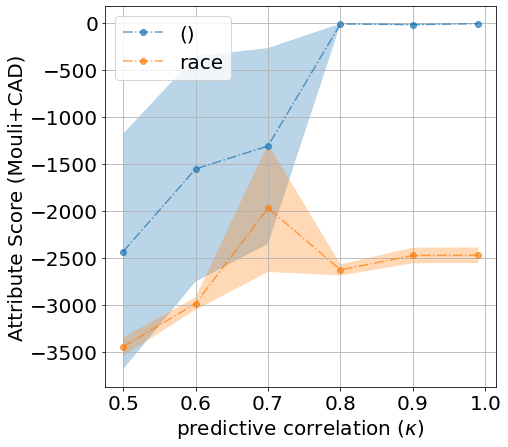

In [5]:
run_list=[0,1,2]
pval_list=[0.5,0.6,0.7,0.8,0.9,0.99]

main_enum=20
topic_name_list = ["race",]
# topic_name_list = ["gender",]
sample=10000

# topic_name_list = ["religion",]
# sample=4000

topic_name_in_fname = topic_name_list[0]
noise=0.0
mvsel_mode="loss"
telambda=0   #1,10,100,1000



mouli_plot_item_list=[
            "best_train_main_metric",
            "best_train_main_random_metric",
            "mouli_score",
            "best_valid_main_acc",
            "best_valid_main_smin_acc",
            "best_valid_main_pdelta",
]


probe_plot_item_list = [
            "acc:main",
            "topic0_smin",
            "topic0_pdelta_all",
]


# combined_plot_item_list = mouli_plot_item_list + probe_plot_item_list
combined_plot_item_list = [
            "mouli_score",
#             "best_valid_main_acc",
#             "best_valid_main_smin_acc",
#             "best_valid_main_pdelta",
]



matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = [7,7*(len(combined_plot_item_list))]
fig,ax = plt.subplots(len(combined_plot_item_list),)




inv_fname_pattern = "dataset/twitter_aae_sentiment_race/nlp_logs/cad.moulis1aae.rnum({}).topic({}).sample({}).noise({}).pval({}).mvsel({}).telambda({}).myrandmode({})/"



avg_mouli_selec_metric_dict=plot_mouli_selection_metrics(ax=ax,
                                     run_list=run_list,
                                     topic_list=topic_name_list,
                                     pval_list=pval_list,
                                     main_enum=main_enum,
                                     mouli_plot_item_list=mouli_plot_item_list,
                                     probe_plot_item_list=probe_plot_item_list,
                                     combined_plot_item_list=combined_plot_item_list,
                                     inv_fname_pattern=inv_fname_pattern.format(
                                                                    "{1}",
                                                                    topic_name_in_fname,
                                                                    sample,
                                                                    noise,
                                                                    "{0}",
                                                                    mvsel_mode,
                                                                    telambda,
                                                                    "{2}",
                                     ),
                                     savename="aae_mouli_score".format(telambda),
)

for pval in pval_list:
    for model in avg_mouli_selec_metric_dict["notrain"].keys():
        print("model:{}\t\t\t score:{}".format(
                                model,
                                avg_mouli_selec_metric_dict["notrain"][model][pval]["mouli_score"]["mean"],
        ))
    print("=====================================================================")
    edge_list = ges_minimize(pval,topic_name_list,avg_mouli_selec_metric_dict)
    print("---------------------------------------------------------------------")
    print("pval:",pval)
    print("selected invariance list: ",get_topic_complement(edge_list,topic_name_list))
    print("---------------------------------------------------------------------\n\n\n\n\n\n\n")
plt.show()